# **Capstone Project - The Battle of Neighborhoods**


## Business Problem 

### **Project Description:** 
XPTO It is a real estate investment company, and in 2021 it intends to invest in the construction of several housing projects.<br>
![Alt text](Lisbon_Neigh.JPG)

With this project we intend to help the XPTO company to choose which neighborhood has the most potential based on the distribution of various facilities available around the neighborhood. This project will use K-mean clustering unsupervised machine learning algorithm to cluster the venues based on the place category such as restaurants, parks, gyms, theaters clubs etc... In order to give a better understanding of the similarities and dissimilarities between the chosen neighborhoods to retrieve more insights and to conclude with ease which neighborhood wins over other.

### **Data:**

• Lisbon City Neighbourhoods:<br>
Using Lisbon city neighborhoods zip codes (CSV or HTTP) to pull the Latitude and Longitude information.<br>
![Alt text](Foursquare_Lisbon.jpg)

• Foursquare API:<br>
Foursquare API provides the ability to perform location search, location sharing and details about a business.This feature enabled to collect the nearby places of the neighborhoods. Due to API request limitations for the free plan, the number of places per neighborhood parameter would reasonably be set to 100 and the radius parameter would be set to 500.

### **Python Libraries:**

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import numpy as np

!pip install folium
import folium # map rendering library

print('Libraries imported.')





Libraries imported.


# Postal Codes in Lisbon

In [2]:
# Loading the dataset which is about postal codes in Lisbon.
df_data = pd.read_csv('http://centraldedados.pt/codigos_postais.csv')

In [3]:
df_data.head(2)

,cod_distrito,cod_concelho,cod_localidade,nome_localidade,cod_arteria,tipo_arteria,prep1,titulo_arteria,prep2,nome_arteria,local_arteria,troco,porta,cliente,num_cod_postal,ext_cod_postal,desig_postal
0,1,1,249,Alcafaz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,11,AGADÃO
1,1,1,250,Caselho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,12,AGADÃO


In [4]:
df_lx = df_data[['nome_arteria','num_cod_postal', 'desig_postal','ext_cod_postal']]
df_lx= df_lx.loc[df_lx['desig_postal'] == 'LISBOA']
df_lx['ext_cod_postal'] = df_lx['ext_cod_postal'].map(lambda x: f'{x:0>3}')
df_lx['PostalCode'] = df_lx['num_cod_postal'].astype(str) + ' ' + 'Lisboa, Portugal'


df_LxNeighs= df_lx.groupby(['num_cod_postal', 'desig_postal', 'PostalCode'])['nome_arteria'].apply(','.join).reset_index()

df_LxNeighs.head()


,num_cod_postal,desig_postal,PostalCode,nome_arteria
0,1000,LISBOA,"1000 Lisboa, Portugal","Cervantes,Cervantes,Chaby Pinheiro,Chaby Pinhe..."
1,1049,LISBOA,"1049 Lisboa, Portugal","Defensores de Chaves,Defensores de Chaves,Defe..."
2,1050,LISBOA,"1050 Lisboa, Portugal","5 de Outubro,5 de Outubro,5 de Outubro,5 de Ou..."
3,1067,LISBOA,"1067 Lisboa, Portugal",Berna
4,1068,LISBOA,"1068 Lisboa, Portugal",Praia da Vitória


# Adding Geographical coordinates to neighborhoods

In [5]:


latitude=[] #List to collect the latitudes
longitude=[] #List to collect the longitudes
address=[]

geolocator = Nominatim(user_agent='Cenas')

for i in df_LxNeighs['PostalCode']: #Iterating through Postalcodes to collect the locations dat
    location = geolocator.geocode(i)

    location.latitude
    location.longitude
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    address.append(location.address)

df_LxNeighs['Latitude']= latitude
df_LxNeighs['Longitude']= longitude
df_LxNeighs['Address']  = address
df_LxNeighsCoord2= df_LxNeighs.groupby(['Address']).first().reset_index()
df_LxNeighsCoord2.head()

,Address,num_cod_postal,desig_postal,PostalCode,nome_arteria,Latitude,Longitude
0,"Alcântara, Lisboa, Grande Lisboa, Área Metropo...",1300,LISBOA,"1300 Lisboa, Portugal","14,César Nogueira,Ceuta,Ceuta,Ceuta,Ceuta,Ceut...",38.701468,-9.190294
1,"Alvalade, Lisboa, Grande Lisboa, Área Metropol...",1600,LISBOA,"1600 Lisboa, Portugal","Konrad Adenauer,Willy Brandt,Cerejais,Cerejeir...",38.752299,-9.165444
2,"Alvalade, Lisboa, Grande Lisboa, Área Metropol...",1700,LISBOA,"1700 Lisboa, Portugal","Odette de Saint-Maurice,Cavaco,Afonso Lopes Vi...",38.751470,-9.146100
3,"Areeiro, Lisboa, Grande Lisboa, Área Metropoli...",1000,LISBOA,"1000 Lisboa, Portugal","Cervantes,Cervantes,Chaby Pinheiro,Chaby Pinhe...",38.743676,-9.139602
4,"Avenidas Novas, Lisboa, Grande Lisboa, Área Me...",1050,LISBOA,"1050 Lisboa, Portugal","5 de Outubro,5 de Outubro,5 de Outubro,5 de Ou...",38.732479,-9.147853


In [6]:
df_LxNeighsCoord2['Neighborhood'] = df_LxNeighsCoord2['Address'].str.split(',').str[0]
df_LxNeighsCoord= df_LxNeighsCoord2.groupby(['Neighborhood']).first().reset_index()
df_LxNeighsCoord

,Neighborhood,Address,num_cod_postal,desig_postal,PostalCode,nome_arteria,Latitude,Longitude
0,Alcântara,"Alcântara, Lisboa, Grande Lisboa, Área Metropo...",1300,LISBOA,"1300 Lisboa, Portugal","14,César Nogueira,Ceuta,Ceuta,Ceuta,Ceuta,Ceut...",38.701468,-9.190294
1,Alvalade,"Alvalade, Lisboa, Grande Lisboa, Área Metropol...",1600,LISBOA,"1600 Lisboa, Portugal","Konrad Adenauer,Willy Brandt,Cerejais,Cerejeir...",38.752299,-9.165444
2,Areeiro,"Areeiro, Lisboa, Grande Lisboa, Área Metropoli...",1000,LISBOA,"1000 Lisboa, Portugal","Cervantes,Cervantes,Chaby Pinheiro,Chaby Pinhe...",38.743676,-9.139602
3,Avenidas Novas,"Avenidas Novas, Lisboa, Grande Lisboa, Área Me...",1050,LISBOA,"1050 Lisboa, Portugal","5 de Outubro,5 de Outubro,5 de Outubro,5 de Ou...",38.732479,-9.147853
4,Beato,"Beato, Lisboa, Grande Lisboa, Área Metropolita...",1900,LISBOA,"1900 Lisboa, Portugal","Casimiro Freire,Casimiro Freire,Afonso Costa,A...",38.726570,-9.111282
5,Belém,"Belém, Lisboa, Grande Lisboa, Área Metropolita...",1400,LISBOA,"1400 Lisboa, Portugal","Afonso Gonçalves Baldaya,14,Afonso de Paiva,Ch...",38.698159,-9.221363
6,Benfica,"Benfica, Lisboa, Grande Lisboa, Área Metropoli...",1500,LISBOA,"1500 Lisboa, Portugal","Casquilha,Casquilha,Casquilha,Casquilha,Casqui...",38.747245,-9.192086
7,Campolide,"Campolide, Lisboa, Grande Lisboa, Área Metropo...",1070,LISBOA,"1070 Lisboa, Portugal","Castilho,Castilho,Celeste,Ceuta,5,5,Columbano ...",38.724247,-9.169787
8,Estrela,"Estrela, Lisboa, Grande Lisboa, Área Metropoli...",1200,LISBOA,"1200 Lisboa, Portugal","Castelo Picão,Castelo Picão,Castelo Picão,Cast...",38.710652,-9.154613
9,Lisboa,"Lisboa, Grande Lisboa, Área Metropolitana de L...",1049,LISBOA,"1049 Lisboa, Portugal","Defensores de Chaves,Defensores de Chaves,Defe...",38.707751,-9.136592


# Lisbon Neighborhoods in Folium Map


Folium makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

In [7]:
import folium # map rendering library
# create map of Lisbon Neighbourhoors using latitude and longitude values
map_Lisbon= folium.Map(location=[38.701468, -9.190294], zoom_start=12)

# add markers to map
for lat, lng, nei in zip(df_LxNeighsCoord['Latitude'], df_LxNeighsCoord['Longitude'], df_LxNeighsCoord['num_cod_postal']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Lisbon)  
    

In [8]:
map_Lisbon

## Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'H0LBRYQCS1N44E0OYAFXNSQSTFU4D2VT5LD145I2SXN5CO1Y' # your Foursquare ID
CLIENT_SECRET = 'IVDBTNWCENNTSOY1HWSFDYIWPNRG3SFRZWA33UPAZSUY3JE3' # your Foursquare Secret
VERSION = '20210212' # Foursquare API version

### Let's explore the first neighborhood in our dataframe.

In [10]:
df_LxNeighsCoord.loc[0, 'Neighborhood']


'Alcântara'

In [60]:

#Get the neighborhood's latitude and longitude values.

neighborhood_latitude = df_LxNeighsCoord.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_LxNeighsCoord.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_LxNeighsCoord.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Alcântara are 38.701467624076244, -9.190293687114348.


In [61]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=H0LBRYQCS1N44E0OYAFXNSQSTFU4D2VT5LD145I2SXN5CO1Y&client_secret=IVDBTNWCENNTSOY1HWSFDYIWPNRG3SFRZWA33UPAZSUY3JE3&v=20210212&ll=38.701467624076244,-9.190293687114348&radius=500&limit=100'

#### Send the GET request and examine the resutls

In [62]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6026bb9babee4e16a16d9391'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Alcântara',
  'headerFullLocation': 'Alcântara, Lisbon',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 30,
  'suggestedBounds': {'ne': {'lat': 38.705967628576246,
    'lng': -9.184538280082911},
   'sw': {'lat': 38.69696761957624, 'lng': -9.196049094145785}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0588a0f964a52085d022e3',
       'name': 'Pestana Palace Hotel & National Monument',
       'location': {'address': 'R. Jau, 54',
        'lat': 38.70368732857484,
        'lng': -9.186756445274398,
        'labeledLatLngs': [{'label': 'display',
  

In [63]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [64]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.id', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,id,lat,lng
0,Pestana Palace Hotel & National Monument,Hotel,4b0588a0f964a52085d022e3,38.703687,-9.186756
1,Raio Laser,Café,4f205162e4b0294b35922151,38.698412,-9.191527
2,São Bernardo,Mediterranean Restaurant,4ce13a813644a093ccee5b9f,38.698733,-9.187355
3,Cordoaria Nacional,Museum,4b157863f964a52051ad23e3,38.697261,-9.190062
4,Espaço Junqueira,Restaurant,4fc379ffe4b027ef15e123f6,38.698910,-9.191906


#### And how many venues were returned by Foursquare?

In [65]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

30 venues were returned by Foursquare.


# FourSquare API

Search and collect all the popular Venues in Lisbon Neighborhoods Radius-700 Limit-100

In [66]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
        CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
Lisbon_venues = getNearbyVenues(names=df_LxNeighsCoord['Neighborhood'],
                                   latitudes=df_LxNeighsCoord['Latitude'],
                                   longitudes=df_LxNeighsCoord['Longitude']
                                  )

Let's check how many venues were returned for each neighborhood

In [68]:
Lisbon_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Alcântara                  30
Alvalade                   24
Areeiro                    54
Avenidas Novas            100
Beato                      11
Belém                      15
Benfica                    27
Campolide                   4
Estrela                    51
Lisboa                     47
Marvila                    10
Parque das Nações          52
Penha de França            32
Santa Maria Maior         100
Santa Maria de Olivais     34
Santo António             100
Name: Venue, dtype: int64

#### Let's check how many venues were returned for each neighborhood

In [69]:
print('There are {} uniques categories.'.format(len(Lisbon_venues['Venue Category'].unique())))

There are 163 uniques categories.


## Analyze Each Neighborhood

In [70]:
# one hot encoding
Lisbon_onehot = pd.get_dummies(Lisbon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Lisbon_onehot['Neighborhood'] = Lisbon_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Lisbon_onehot.columns[-1]] + list(Lisbon_onehot.columns[:-1])
Lisbon_onehot = Lisbon_onehot[fixed_columns]

Lisbon_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,BBQ Joint,Bakery,Bar,...,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store
0,Alcântara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alcântara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alcântara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alcântara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alcântara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
Lisbon_grouped = Lisbon_onehot.groupby('Neighborhood').mean().reset_index()
Lisbon_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,BBQ Joint,Bakery,Bar,...,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store
0,Alcântara,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.033333,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
1,Alvalade,0.00,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
2,Areeiro,0.00,0.000000,0.000000,0.000000,0.018519,0.000000,0.037037,0.037037,0.055556,...,0.000000,0.018519,0.018519,0.00,0.018519,0.000000,0.000000,0.000000,0.00,0.00
3,Avenidas Novas,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.040000,0.010000,...,0.000000,0.010000,0.010000,0.00,0.000000,0.030000,0.000000,0.000000,0.00,0.00
4,Beato,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
5,Belém,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.00,0.00
6,Benfica,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.037037,0.000000,0.000000,0.00,0.00
7,Campolide,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
8,Estrela,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.019608,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.019608,0.00,0.00
9,Lisboa,0.00,0.000000,0.021277,0.000000,0.000000,0.021277,0.000000,0.000000,0.085106,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.021277,0.042553,0.00,0.00


#### Let's print each neighborhood along with the top 3 most common venues

In [88]:
num_top_venues = 3

for hood in Lisbon_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Lisbon_grouped[Lisbon_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alcântara----
          venue  freq
0    Restaurant  0.17
1  Soccer Field  0.07
2         Plaza  0.07


----Alvalade----
               venue  freq
0               Café  0.17
1  College Cafeteria  0.08
2                Gym  0.08


----Areeiro----
                   venue  freq
0  Portuguese Restaurant  0.09
1                   Café  0.07
2                    Bar  0.06


----Avenidas Novas----
        venue  freq
0  Restaurant  0.11
1       Hotel  0.11
2        Café  0.05


----Beato----
          venue  freq
0    Restaurant  0.18
1  Dance Studio  0.09
2       Theater  0.09


----Belém----
                   venue  freq
0    Japanese Restaurant  0.13
1            Pizza Place  0.13
2  Portuguese Restaurant  0.13


----Benfica----
                   venue  freq
0                   Café  0.15
1  Portuguese Restaurant  0.11
2                 Bakery  0.11


----Campolide----
            venue  freq
0  Ice Cream Shop  0.25
1    Soccer Field  0.25
2    Hockey Arena  0.25


----Estrela----


#### Let's put that into a _pandas_ dataframe

In [89]:
def return_most_common_venues(row
                              , num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [134]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Lisbon_grouped['Neighborhood']

for ind in np.arange(Lisbon_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Lisbon_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alcântara,Restaurant,Snack Place,Soccer Field,Portuguese Restaurant,Café
1,Alvalade,Café,Sushi Restaurant,Portuguese Restaurant,College Cafeteria,Gym
2,Areeiro,Portuguese Restaurant,Café,Bar,BBQ Joint,Restaurant
3,Avenidas Novas,Restaurant,Hotel,Café,Bakery,Hostel
4,Beato,Restaurant,Dance Studio,Supermarket,Cafeteria,Museum
5,Belém,Portuguese Restaurant,Pizza Place,Japanese Restaurant,Bakery,Restaurant
6,Benfica,Café,Portuguese Restaurant,Bakery,Pizza Place,Gym
7,Campolide,Ice Cream Shop,Soccer Field,Hockey Arena,Bakery,Farm
8,Estrela,Portuguese Restaurant,Restaurant,Italian Restaurant,Coffee Shop,BBQ Joint
9,Lisboa,Portuguese Restaurant,Bar,Hostel,Plaza,Wine Bar


##  Cluster Neighborhoods

#### Run _k_-means to cluster the neighborhood into 5 clusters

In [131]:
# set number of clusters
kclusters = 6

Lisbon_grouped_clustering = Lisbon_grouped.drop('Neighborhood', 1)
print(Lisbon_grouped_clustering)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Lisbon_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

    Accessories Store  Adult Boutique  African Restaurant  Aquarium  \
0                0.00        0.000000            0.000000  0.000000   
1                0.00        0.041667            0.000000  0.000000   
2                0.00        0.000000            0.000000  0.000000   
3                0.00        0.000000            0.000000  0.000000   
4                0.00        0.000000            0.000000  0.000000   
5                0.00        0.000000            0.000000  0.000000   
6                0.00        0.000000            0.000000  0.000000   
7                0.00        0.000000            0.000000  0.000000   
8                0.00        0.000000            0.000000  0.000000   
9                0.00        0.000000            0.021277  0.000000   
10               0.00        0.000000            0.000000  0.000000   
11               0.00        0.000000            0.000000  0.019231   
12               0.00        0.000000            0.000000  0.000000   
13    

array([1, 5, 1, 1, 0, 1, 5, 3, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [132]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Lisbon_merged = df_LxNeighsCoord

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Lisbon_merged = Lisbon_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lisbon_merged.head() # check the last columns!

,Neighborhood,Address,num_cod_postal,desig_postal,PostalCode,nome_arteria,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alcântara,"Alcântara, Lisboa, Grande Lisboa, Área Metropo...",1300,LISBOA,"1300 Lisboa, Portugal","14,César Nogueira,Ceuta,Ceuta,Ceuta,Ceuta,Ceut...",38.701468,-9.190294,1,Restaurant,Snack Place,Soccer Field,Portuguese Restaurant,Café
1,Alvalade,"Alvalade, Lisboa, Grande Lisboa, Área Metropol...",1600,LISBOA,"1600 Lisboa, Portugal","Konrad Adenauer,Willy Brandt,Cerejais,Cerejeir...",38.752299,-9.165444,5,Café,Sushi Restaurant,Portuguese Restaurant,College Cafeteria,Gym
2,Areeiro,"Areeiro, Lisboa, Grande Lisboa, Área Metropoli...",1000,LISBOA,"1000 Lisboa, Portugal","Cervantes,Cervantes,Chaby Pinheiro,Chaby Pinhe...",38.743676,-9.139602,1,Portuguese Restaurant,Café,Bar,BBQ Joint,Restaurant
3,Avenidas Novas,"Avenidas Novas, Lisboa, Grande Lisboa, Área Me...",1050,LISBOA,"1050 Lisboa, Portugal","5 de Outubro,5 de Outubro,5 de Outubro,5 de Ou...",38.732479,-9.147853,1,Restaurant,Hotel,Café,Bakery,Hostel
4,Beato,"Beato, Lisboa, Grande Lisboa, Área Metropolita...",1900,LISBOA,"1900 Lisboa, Portugal","Casimiro Freire,Casimiro Freire,Afonso Costa,A...",38.726570,-9.111282,0,Restaurant,Dance Studio,Supermarket,Cafeteria,Museum


Finally, let's visualize the resulting clusters

In [133]:
# create map
map_clusters = folium.Map(location=[38.701468, -9.190294], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Lisbon_merged['Latitude'], Lisbon_merged['Longitude'], Lisbon_merged['Neighborhood'], Lisbon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1

In [129]:
Lisbon_merged.loc[Lisbon_merged['Cluster Labels'] == 0, Lisbon_merged.columns[[1] + list(range(5, Lisbon_merged.shape[1]))]]

,Address,nome_arteria,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Alcântara, Lisboa, Grande Lisboa, Área Metropo...","14,César Nogueira,Ceuta,Ceuta,Ceuta,Ceuta,Ceut...",38.701468,-9.190294,0,Restaurant,Snack Place,Soccer Field,Portuguese Restaurant,Café


#### Cluster 2

In [121]:
Lisbon_merged.loc[Lisbon_merged['Cluster Labels'] == 1, Lisbon_merged.columns[[1] + list(range(5, Lisbon_merged.shape[1]))]]

,Address,nome_arteria,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,"Parque das Nações, Lisboa, Grande Lisboa, Área...","Bicas,Sextante,Balestilha,Velas,Cais das Naus,...",38.765768,-9.09618,1,Ice Cream Shop,Electronics Store,Burger Joint,Gym / Fitness Center,Clothing Store


#### Cluster 3

In [122]:
Lisbon_merged.loc[Lisbon_merged['Cluster Labels'] == 2, Lisbon_merged.columns[[1] + list(range(5, Lisbon_merged.shape[1]))]]

,Address,nome_arteria,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,"Campolide, Lisboa, Grande Lisboa, Área Metropo...","Castilho,Castilho,Celeste,Ceuta,5,5,Columbano ...",38.724247,-9.169787,2,Ice Cream Shop,Soccer Field,Hockey Arena,Bakery,Farm


#### Cluster 4

In [123]:
Lisbon_merged.loc[Lisbon_merged['Cluster Labels'] == 3, Lisbon_merged.columns[[1] + list(range(5, Lisbon_merged.shape[1]))]]

,Address,nome_arteria,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,"Estrela, Lisboa, Grande Lisboa, Área Metropoli...","Castelo Picão,Castelo Picão,Castelo Picão,Cast...",38.710652,-9.154613,3,Portuguese Restaurant,Restaurant,Italian Restaurant,Coffee Shop,BBQ Joint
9,"Lisboa, Grande Lisboa, Área Metropolitana de L...","Defensores de Chaves,Defensores de Chaves,Defe...",38.707751,-9.136592,3,Portuguese Restaurant,Bar,Hostel,Plaza,Wine Bar
13,"Santa Maria Maior, Lisboa, Grande Lisboa, Área...","Castelo,Castelo,Castelo Picão,Castelo Picão,Ca...",38.711086,-9.133685,3,Portuguese Restaurant,Hotel,Hostel,Wine Bar,Café


# Elbow Curve to find the optimum number of clusters

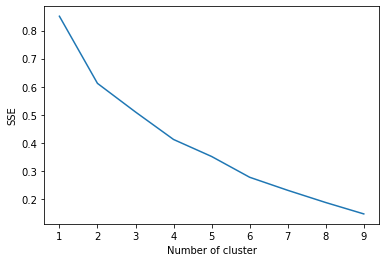

In [124]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import numpy as np

Lisbon_grouped_clustering = Lisbon_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Lisbon_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4413253147581664
For n_clusters = 3 The average silhouette_score is : 0.24153453722233748
For n_clusters = 4 The average silhouette_score is : 0.16749450907175745
For n_clusters = 5 The average silhouette_score is : 0.10387744379057998
For n_clusters = 6 The average silhouette_score is : 0.04933683030561553


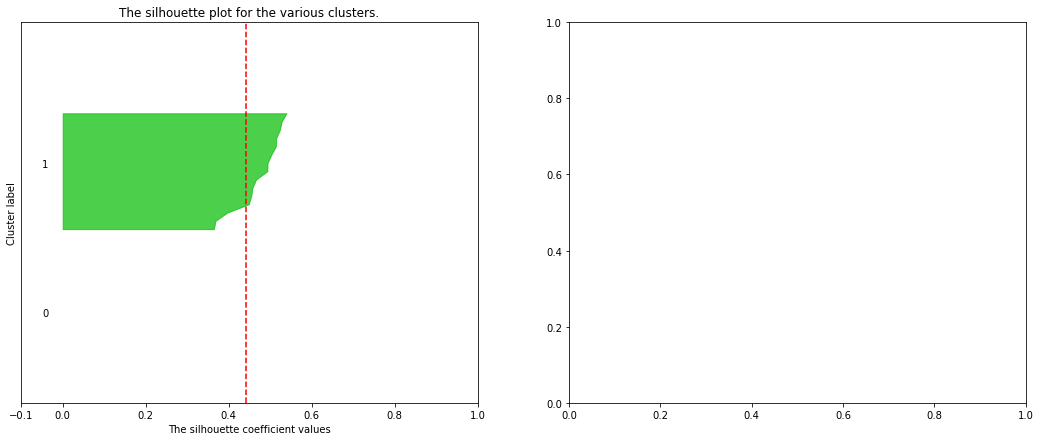

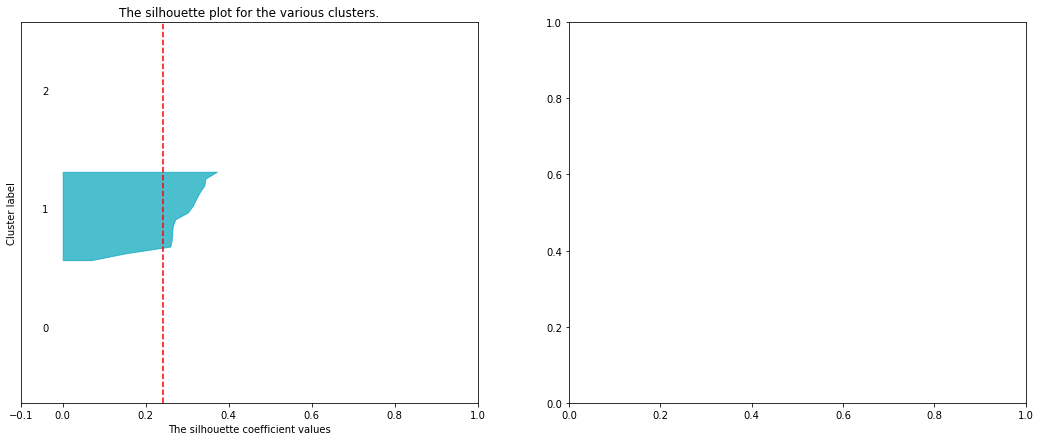

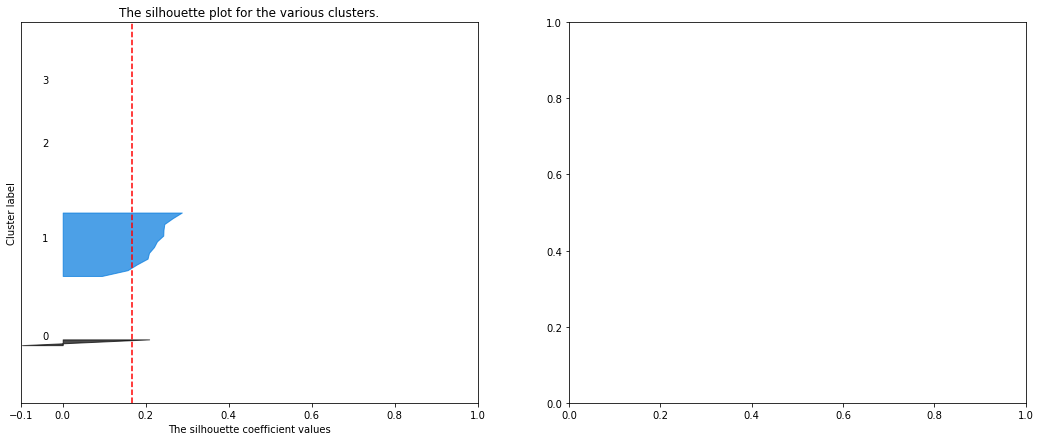

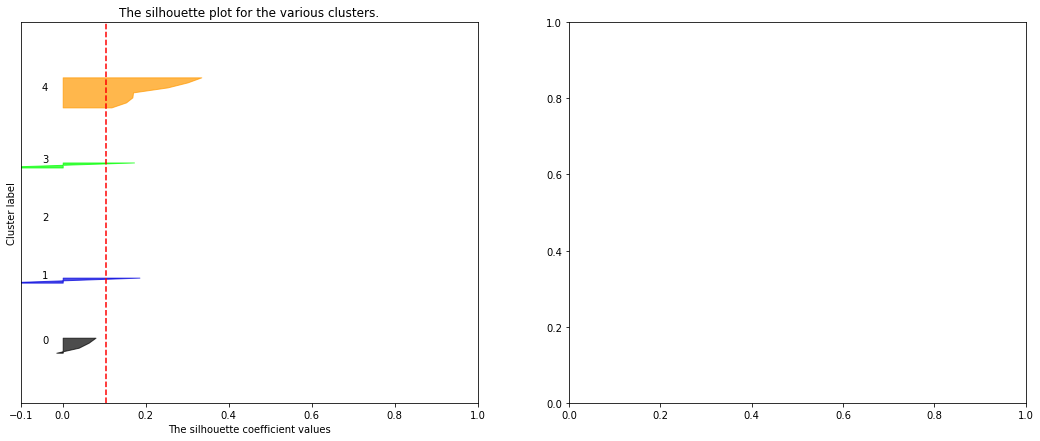

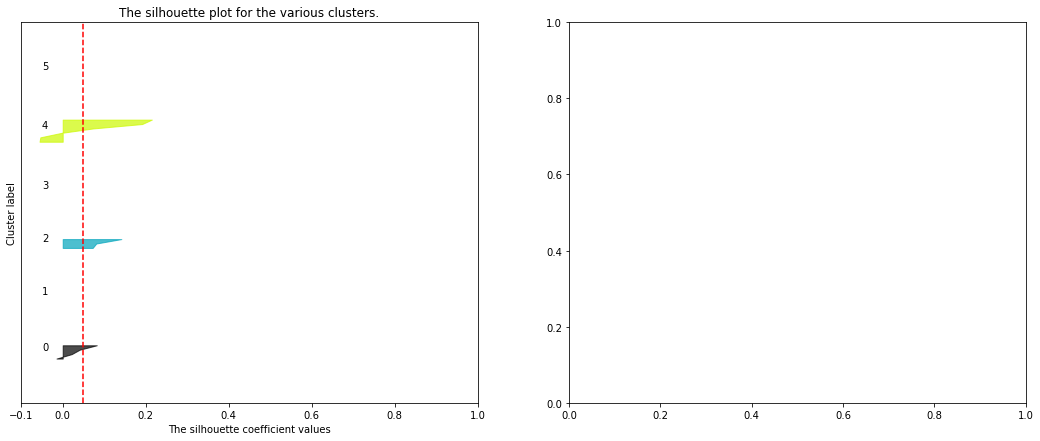

In [125]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Lisbon_grouped_clustering) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Lisbon_grouped_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Lisbon_grouped_clustering, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Lisbon_grouped_clustering, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
plt.show()

In [126]:
Lisbon_grouped_clustering

,Accessories Store,Adult Boutique,African Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,BBQ Joint,Bakery,Bar,Bed & Breakfast,...,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
1,0.00,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
2,0.00,0.000000,0.000000,0.000000,0.018519,0.000000,0.037037,0.037037,0.055556,0.000000,...,0.000000,0.018519,0.018519,0.00,0.018519,0.000000,0.000000,0.000000,0.00,0.00
3,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.040000,0.010000,0.000000,...,0.000000,0.010000,0.010000,0.00,0.000000,0.030000,0.000000,0.000000,0.00,0.00
4,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
5,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.00,0.00
6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.037037,0.000000,0.000000,0.00,0.00
7,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
8,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.019608,0.019608,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.019608,0.00,0.00
9,0.00,0.000000,0.021277,0.000000,0.000000,0.021277,0.000000,0.000000,0.085106,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.021277,0.042553,0.00,0.00



## Number of Venues by Neighbourhood

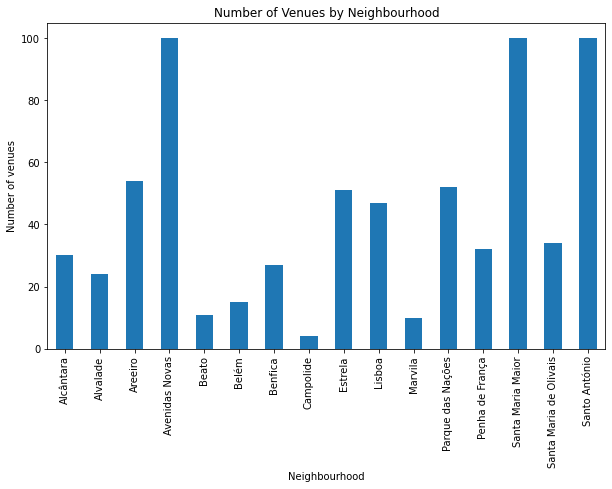

In [114]:
x=[]
x = Lisbon_venues.groupby('Neighborhood')['Venue'].count()
x.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of Venues by Neighbourhood') # add title to the plot

plt.show()

In [115]:
y=[]
y = Lisbon_venues.groupby(['Venue Category','Neighborhood'])['Venue'].count()
y

Venue Category      Neighborhood     
Accessories Store   Santo António        1
Adult Boutique      Alvalade             1
African Restaurant  Lisboa               1
                    Santa Maria Maior    1
Aquarium            Parque das Nações    1
                                        ..
Wine Bar            Estrela              1
                    Lisboa               2
                    Santa Maria Maior    7
Wine Shop           Santa Maria Maior    1
Women's Store       Santo António        1
Name: Venue, Length: 405, dtype: int64

# **Conclusion:**

This Analysis concludes that the three best neighbourhoods of Lisbon are Avenidas Novas, Santa Maria Maior e Santo Antonio, with great amout of spots
<br><br>
This study helps user to compare the neighborhoods and recommend options with data.

